# What is Beta in Finance?

Beta ($\beta$) is a measure of a stock's volatility relative to the overall market or a reference stock. It is often used to assess the risk of an investment compared to the broader market. A stock with a high beta is more volatile and thus riskier than the market, while a low-beta stock is less volatile.

## Definition of Beta

Beta is defined as:

$$\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}$$

Where:
- R_i: Return of the individual stock
- R_m: Return of the market index
- $\text{Cov}(R_i, R_m)$: Covariance between the stock's returns and the market's returns
- $\text{Var}(R_m)$: Variance of the market's returns

## Interpretation of Beta

- **$\beta = 1$**: The stock's returns move in perfect correlation with the market. It has the same risk as the market.
- **$\beta > 1$**: The stock is more volatile than the market.
- **$\beta < 1$**: The stock is less volatile than the market.
- **$\beta < 0$**: Rare but possible, indicating the stock moves inversely to the market.

For more information, refer to [this link](https://www.investopedia.com/investing/beta-know-risk/).

# Beta Prediction Model
This notebook included a robust 45-day forward-looking Beta (the Beta calculated using data for the next 45 days) prediction model.

## Objectives:

- Build a robust model that accurately predicts the 45-day forward-looking Beta for a given stock.
- Evaluate to a 'Baseline' model that predicts the average value of beta every time, we expect a significant improvement.
- Find relevant features to understand the factors predicting Beta.

## Results:

- Best performing model: Random Forest Regressor. We calculated a RMSE of 0.27 and a r2-score of 0.78. For a target with an average of about 1 and a STD of 0.57, this represents an average difference of less than 30% to the real value and a 53% decrease compared to a 'Baseline' model that guesses the mean value everytime.The R2 score of 0.78 implies that 78% of the variance in the target variable is explained by this model, compared to 0% in the simple 'Baseline' model.
- After extracting the Feature Importances, the results show that for linear regression, the 45-day past Covariances are the most relevant feature by far. However, for the RF and GB Regressors the 45-day past Beta is the largest predictor of the 45-day future beta.

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# Feature Engineering and Data Preprocessing

### We use the yfinance library to extract data for 100 random stocks belonging to the S&P 500 from the last 10 years and use the S&P 500 itself as a reference (market) to calculate the covariances and betas

In [3]:
# Fetch S&P 500 tickers from a public source (wikipedia in this case)
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(sp500_url)[0]  # The first table on the page
sp500_tickers = table['Symbol'].tolist()

# Randomly select a specified number of tickers
num_tickers_to_select = 100
random.seed(123)
stocks = random.sample(sp500_tickers, num_tickers_to_select)

print(stocks)

['AXP', 'DRI', 'ANET', 'RTX', 'GE', 'DHR', 'BKR', 'SYF', 'UAL', 'TJX', 'GOOGL', 'FITB', 'KMB', 'LEN', 'EOG', 'EQIX', 'TRGP', 'ZTS', 'CZR', 'BWA', 'EQT', 'WELL', 'WFC', 'PCAR', 'GLW', 'CPB', 'MMM', 'URI', 'HIG', 'REGN', 'ZBRA', 'TT', 'MA', 'FIS', 'ANSS', 'ABBV', 'EBAY', 'PNW', 'HES', 'AVB', 'AMZN', 'T', 'NDSN', 'AVGO', 'BLK', 'ROST', 'APD', 'DG', 'GDDY', 'LMT', 'IEX', 'CVS', 'HUM', 'SMCI', 'ALL', 'YUM', 'DTE', 'EQR', 'JPM', 'STX', 'INCY', 'CI', 'SO', 'MRK', 'MCO', 'K', 'LLY', 'SPG', 'VLO', 'AMD', 'FOX', 'WMB', 'MSI', 'JBL', 'HAL', 'NXPI', 'KIM', 'MNST', 'CRM', 'UNP', 'VRSK', 'IR', 'JCI', 'NSC', 'GIS', 'FRT', 'JBHT', 'ALLE', 'PSA', 'SNPS', 'CDW', 'PCG', 'ACGL', 'PODD', 'NWSA', 'CMI', 'CCL', 'EPAM', 'WMT', 'LRCX']


In [4]:
# Define the reference market index and download data
reference_index = '^GSPC'  # S&P 500
today = datetime.now()
start_date = today - timedelta(days=10 * 365)
data = yf.download(stocks + [reference_index], start=start_date, end=today)
data.head(10)

[*********************100%***********************]  101 of 101 completed


Price                      Adj Close                                         \
Ticker                          ABBV       ACGL        ALL       ALLE   AMD   
Date                                                                          
2015-01-02 00:00:00+00:00  43.563179  19.496668  56.303619  49.587273  2.67   
2015-01-05 00:00:00+00:00  42.743355  19.379999  55.187504  49.488171  2.66   
2015-01-06 00:00:00+00:00  42.531788  19.423332  55.147354  49.407112  2.63   
2015-01-07 00:00:00+00:00  44.250786  19.536667  56.054688  50.082684  2.58   
2015-01-08 00:00:00+00:00  44.713585  19.876667  57.130665  50.758274  2.61   
2015-01-09 00:00:00+00:00  43.490459  19.703333  56.544502  50.334911  2.63   
2015-01-12 00:00:00+00:00  43.477230  19.643333  55.966377  49.533226  2.63   
2015-01-13 00:00:00+00:00  42.224945  19.719999  56.303619  49.632305  2.66   
2015-01-14 00:00:00+00:00  42.431442  19.633333  55.749584  49.839497  2.63   
2015-01-15 00:00:00+00:00  41.891880  19.706667  55.588978  48.461300  2.52   

Price                                                                \
Ticker                        AMZN      ANET       ANSS         APD   
Date                                                                  
2015-01-02 00:00:00+00:00  15.4260  3.917500  81.639999  106.267914   
2015-01-05 00:00:00+00:00  15.1095  3.987500  80.860001  102.870102   
2015-01-06 00:00:00+00:00  14.7645  3.988125  79.260002  102.833557   
2015-01-07 00:00:00+00:00  14.9210  4.071250  79.709999  103.944267   
2015-01-08 00:00:00+00:00  15.0230  4.132500  81.660004  106.348297   
2015-01-09 00:00:00+00:00  14.8465  4.151250  80.760002  104.755348   
2015-01-12 00:00:00+00:00  14.5705  4.129375  79.919998  104.031944   
2015-01-13 00:00:00+00:00  14.7370  4.079375  80.629997  103.483917   
2015-01-14 00:00:00+00:00  14.6635  4.066250  80.720001  102.248985   
2015-01-15 00:00:00+00:00  14.3475  3.950625  80.830002  101.905556   

Price                                  ...    Volume                   \
Ticker                            AVB  ...       VLO    VRSK     WELL   
Date                                   ...                              
2015-01-02 00:00:00+00:00  120.295784  ...   5897000  529700  1794700   
2015-01-05 00:00:00+00:00  121.108353  ...   7732700  885800  2066500   
2015-01-06 00:00:00+00:00  122.755203  ...   8586800  754600  2897700   
2015-01-07 00:00:00+00:00  124.177231  ...   8825800  632100  2736500   
2015-01-08 00:00:00+00:00  125.330757  ...   8941700  890800  2459700   
2015-01-09 00:00:00+00:00  125.715294  ...   8475100  561800  1845600   
2015-01-12 00:00:00+00:00  126.803520  ...   6898700  472400  1644900   
2015-01-13 00:00:00+00:00  126.672943  ...  10932800  575300  1908400   
2015-01-14 00:00:00+00:00  128.305328  ...  13608500  484000  2302200   
2015-01-15 00:00:00+00:00  128.776917  ...  11217200  479700  3080900   

Price                                                                    \
Ticker                          WFC      WMB       WMT      YUM    ZBRA   
Date                                                                      
2015-01-02 00:00:00+00:00  11700900  7433500  13505400  2283466  411800   
2015-01-05 00:00:00+00:00  15000500  8826800  20937000  4418651  420300   
2015-01-06 00:00:00+00:00  20211200  8068100  24615300  5004401  527500   
2015-01-07 00:00:00+00:00  15714700  8252000  25495200  4554134  467800   
2015-01-08 00:00:00+00:00  16721600  7745700  38140800  4258268  324400   
2015-01-09 00:00:00+00:00  14550800  6264400  25567500  3687263  561300   
2015-01-12 00:00:00+00:00  16967500  6567400  22117500  3924428  638100   
2015-01-13 00:00:00+00:00  25080900  7258000  24646200  4612417  856000   
2015-01-14 00:00:00+00:00  37590100  9703200  35862900  5022206  376600   
2015-01-15 00:00:00+00:00  32144700  7674800  28238100  5393742  675900   

Price                                           
Ticker                         ZTS       ^GSPC  
Date                    

In [5]:
# Get some info about our data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 00:00:00+00:00 to 2024-12-30 00:00:00+00:00
Columns: 606 entries, ('Adj Close', 'ABBV') to ('Volume', '^GSPC')
dtypes: float64(508), int64(98)
memory usage: 11.6 MB


In [6]:
# Calculate daily returns
daily_returns = data['Adj Close'].pct_change().dropna()
daily_returns.head(10)

Ticker,ABBV,ACGL,ALL,ALLE,AMD,AMZN,ANET,ANSS,APD,AVB,...,VLO,VRSK,WELL,WFC,WMB,WMT,YUM,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14 00:00:00+00:00,0.012922,0.004010,0.003207,-0.006714,-0.023952,-0.002715,0.000342,-0.001051,0.000594,0.003511,...,0.008549,-0.002957,0.006462,0.008614,0.001083,-0.002843,0.003447,0.005389,-0.007531,-0.000868
2019-03-15 00:00:00+00:00,0.017386,0.009831,0.010549,-0.004055,0.020596,0.015502,0.014183,-0.001329,-0.001944,-0.005498,...,0.001648,0.002342,-0.007576,0.006157,-0.006130,0.002036,0.019398,-0.005972,0.007380,0.004985
2019-03-18 00:00:00+00:00,-0.008483,-0.000913,0.001898,0.005542,-0.001718,0.017397,0.008222,0.002883,0.002813,-0.008896,...,0.019629,0.002024,-0.019666,0.021121,0.008345,0.012599,-0.006541,0.008562,0.008874,0.003706
2019-03-19 00:00:00+00:00,0.002108,-0.014616,-0.008525,-0.002137,0.118280,0.011308,-0.013436,0.001216,-0.002536,-0.003955,...,-0.003689,0.001399,-0.006599,-0.006186,0.012235,0.001906,-0.009976,0.002204,0.009717,-0.000131
2019-03-20 00:00:00+00:00,-0.004826,-0.011743,-0.012419,-0.010934,-0.011538,0.020104,0.011078,-0.004914,-0.001352,0.001222,...,0.000116,-0.004501,0.003056,-0.019646,0.007821,-0.012118,-0.006751,0.004259,-0.002229,-0.002944
2019-03-21 00:00:00+00:00,0.010071,0.009694,0.016660,0.013221,0.085214,0.012235,0.055520,0.011652,0.013756,0.010271,...,-0.000694,0.011458,0.028742,-0.010714,0.020459,0.004258,0.006290,0.017289,0.011574,0.010852
2019-03-22 00:00:00+00:00,-0.018218,-0.007123,-0.004440,-0.018897,-0.054500,-0.029952,-0.047172,-0.028246,-0.004754,0.004580,...,-0.020259,-0.006704,0.001931,-0.031087,-0.015901,-0.007874,-0.002218,-0.050664,-0.017162,-0.018975
2019-03-25 00:00:00+00:00,-0.003134,-0.002807,-0.001911,0.002637,-0.015169,0.005377,0.003565,0.001467,-0.002040,-0.002104,...,0.010044,0.006983,0.007453,-0.004761,0.008079,-0.001119,0.000000,-0.010954,0.000000,-0.000839
2019-03-26 00:00:00+00:00,0.015721,-0.000313,0.001170,0.011092,-0.010782,0.005354,0.028450,0.012680,0.006670,0.008535,...,0.017782,0.014793,0.004081,0.019343,-0.003136,0.001528,-0.002223,0.019417,0.009088,0.007183


### Now we want to calculate the 45-day forward-looking Beta for our stocks (our target) but we also need to create some features that can be useful for our model. We therefore calculate the variances, covariances and betas but also correlations and mean volumes

In [7]:
# Calculate market's Variances and Covariances taking the last 45 days for each day and define the beta
variances45 = daily_returns['^GSPC'].rolling(45).var()
covariances45 = daily_returns.rolling(45).cov(daily_returns['^GSPC'])
beta45 = covariances45.div(variances45, axis=0)
# We look at the tail of the betas
beta45.tail(10)

Ticker,ABBV,ACGL,ALL,ALLE,AMD,AMZN,ANET,ANSS,APD,AVB,...,VLO,VRSK,WELL,WFC,WMB,WMT,YUM,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-16 00:00:00+00:00,0.166409,1.312065,0.747828,0.203473,1.849956,1.746943,1.975689,1.484655,0.327902,0.409556,...,0.776034,0.257661,0.253509,1.629454,0.795148,0.170079,0.507946,1.129111,0.096475,1.0
2024-12-17 00:00:00+00:00,0.079720,1.420510,0.740119,0.161415,1.922571,1.836727,2.114222,1.450030,0.302898,0.393460,...,0.801485,0.263689,0.184536,1.643351,0.789891,0.172901,0.505105,1.195884,0.106905,1.0
2024-12-18 00:00:00+00:00,0.149973,1.106499,0.787450,0.418010,1.473384,1.818813,1.823571,1.261117,0.552699,0.634726,...,0.683315,0.370936,0.462744,1.528850,0.889831,0.403578,0.582561,1.141961,0.283364,1.0
2024-12-19 00:00:00+00:00,0.161840,1.113389,0.769293,0.405507,1.485419,1.840931,1.781025,1.293389,0.537885,0.627934,...,0.681468,0.368387,0.456163,1.521324,0.878761,0.421442,0.587562,1.148232,0.269619,1.0
2024-12-20 00:00:00+00:00,0.245750,1.167284,0.812351,0.445977,1.460042,1.781596,1.828636,1.283794,0.549408,0.688834,...,0.657129,0.366760,0.467960,1.533969,0.905055,0.348299,0.621596,1.171831,0.298617,1.0
2024-12-23 00:00:00+00:00,0.279233,1.182504,0.804623,0.436564,1.555287,1.748390,1.825878,1.272457,0.522450,0.667162,...,0.650634,0.358744,0.468065,1.520408,0.898483,0.287708,0.635690,1.137787,0.276683,1.0
2024-12-24 00:00:00+00:00,0.293851,1.178105,0.798708,0.451217,1.577932,1.732280,1.806766,1.258783,0.542903,0.660034,...,0.637648,0.366951,0.468872,1.504601,0.892425,0.348945,0.640785,1.130097,0.273935,1.0
2024-12-26 00:00:00+00:00,0.300171,1.174648,0.798834,0.447816,1.572272,1.736792,1.797015,1.259543,0.542753,0.661014,...,0.635745,0.366444,0.469581,1.508566,0.899018,0.354311,0.636213,1.128190,0.272304,1.0
2024-12-27 00:00:00+00:00,0.306005,1.158293,0.823787,0.474701,1.521275,1.688300,1.815706,1.212005,0.527295,0.756117,...,0.563371,0.365046,0.545361,1.512503,0.886366,0.445402,0.665274,1.154989,0.279300,1.0


In [8]:
# We also calculate the Variances and Covariances taking the last 20 days
variances20 = daily_returns['^GSPC'].rolling(20).var()
covariances20 = daily_returns.rolling(20).cov(daily_returns['^GSPC'])
beta20 = covariances20.div(variances20, axis=0)

In [9]:
# Similarly we calculate correlations and mean volumes of last 45 and 20 days
correlations45 = daily_returns.rolling(45).corr(daily_returns['^GSPC'])
volume45 = data['Volume'].rolling(45).mean()
correlations20 = daily_returns.rolling(20).corr(daily_returns['^GSPC'])
volume20 = data['Volume'].rolling(20).mean()

In [10]:
# Now we create our target, the 45-day forward-looking beta. We just take the 45-day past beta and shift it 45 days
beta45_forward = beta45.shift(periods=-45)
beta45_forward.head(10)

Ticker,ABBV,ACGL,ALL,ALLE,AMD,AMZN,ANET,ANSS,APD,AVB,...,VLO,VRSK,WELL,WFC,WMB,WMT,YUM,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14 00:00:00+00:00,0.789775,0.936392,0.915748,1.171285,2.610506,1.535722,1.597463,1.515868,0.807763,0.318570,...,1.339156,0.817576,0.142450,0.795719,0.681999,0.723272,0.499243,2.361188,0.848594,1.0
2019-03-15 00:00:00+00:00,0.731730,0.902124,0.875877,1.194544,2.649408,1.513222,1.594652,1.550707,0.881370,0.367045,...,1.378294,0.828739,0.191455,0.780271,0.690262,0.694662,0.474118,2.425043,0.822771,1.0
2019-03-18 00:00:00+00:00,0.772802,0.935863,0.886761,1.204513,2.668745,1.445541,1.665984,1.530818,0.877724,0.399103,...,1.334402,0.848137,0.247273,0.802573,0.716128,0.644569,0.509701,2.459789,0.793259,1.0
2019-03-19 00:00:00+00:00,0.759375,0.914306,0.880268,1.222385,2.677314,1.441775,1.652799,1.528080,0.881377,0.390921,...,1.360635,0.841798,0.243592,0.802440,0.727128,0.628891,0.510807,2.471842,0.785849,1.0
2019-03-20 00:00:00+00:00,0.740433,0.914531,0.875085,1.192865,2.707116,1.505086,1.542879,1.580794,0.888878,0.364820,...,1.574607,0.856088,0.173564,0.784111,0.802291,0.600438,0.480861,2.406729,0.746905,1.0
2019-03-21 00:00:00+00:00,0.723844,0.920718,0.846837,1.202634,2.453512,1.526583,1.354201,1.612317,0.879672,0.344259,...,1.651795,0.854710,0.059338,0.872791,0.742911,0.618868,0.475867,2.441883,0.731319,1.0
2019-03-22 00:00:00+00:00,0.759509,1.024716,0.973038,1.202443,1.908484,1.435841,1.176367,1.615954,0.989880,0.477628,...,1.765509,0.905917,0.149062,0.769244,0.798669,0.637347,0.565186,2.336638,0.687955,1.0
2019-03-25 00:00:00+00:00,0.740403,0.981183,0.914217,1.218210,1.973618,1.438964,1.215132,1.601065,0.961909,0.489946,...,1.734243,0.947107,0.166875,0.755722,0.789116,0.635440,0.558553,2.403529,0.702762,1.0
2019-03-26 00:00:00+00:00,0.695968,1.010017,0.934446,1.232539,2.059983,1.453255,1.135790,1.602532,0.972745,0.472881,...,1.676906,0.927830,0.172510,0.692725,0.827526,0.648011,0.600771,2.389099,0.701840,1.0


### We have created the necessary features and calculated our target value, Beta=1 for the S&P 500 as it should. Now let's lump all this into a Dataframe

In [11]:
# Concat all relevant dataframes into one
df_all_features = pd.concat(
    [daily_returns, covariances45, correlations45, volume45, beta45, covariances20, correlations20, volume20, beta20, beta45_forward],
    axis=1,
    keys=['Returns', 'Covariances 45', 'Correlations 45', 'Volume Mean 45', 'Beta 45', 'Covariances 20', 'Correlations 20', 'Volume Mean 20', 'Beta 20','Beta 45 Forward']
).dropna()
# Drop the reference stock since it won't be used for training
df_all_features = df_all_features.loc[:, df_all_features.columns.get_level_values(1) != reference_index]
# Show result
df_all_features.head(10)

Returns                                          \
Ticker                         ABBV      ACGL       ALL      ALLE       AMD   
Date                                                                          
2019-05-16 00:00:00+00:00  0.009139  0.013807  0.003980  0.014339  0.015591   
2019-05-17 00:00:00+00:00 -0.000503 -0.021153 -0.002399 -0.013743 -0.018208   
2019-05-20 00:00:00+00:00  0.004531  0.002368  0.003137 -0.004877 -0.029818   
2019-05-21 00:00:00+00:00  0.013280  0.015948  0.010110  0.015003  0.025112   
2019-05-22 00:00:00+00:00  0.008779  0.013372  0.001857 -0.015274  0.002194   
2019-05-23 00:00:00+00:00 -0.005393 -0.012048 -0.011432 -0.008306 -0.038307   
2019-05-24 00:00:00+00:00 -0.013432 -0.001161  0.004063  0.001817  0.003035   
2019-05-28 00:00:00+00:00 -0.025356 -0.012500 -0.013282 -0.004633  0.098714   
2019-05-29 00:00:00+00:00  0.000385  0.007654  0.011989 -0.010423 -0.033046   
2019-05-30 00:00:00+00:00 -0.005765  0.001169  0.001671  0.017282 -0.002136   

                                                                             \
Ticker                         AMZN      ANET      ANSS       APD       AVB   
Date                                                                          
2019-05-16 00:00:00+00:00  0.019464  0.019783  0.024017  0.021510  0.010264   
2019-05-17 00:00:00+00:00 -0.020219 -0.013800 -0.020424  0.002340  0.001874   
2019-05-20 00:00:00+00:00 -0.005366 -0.020670 -0.015251 -0.021484 -0.012750   
2019-05-21 00:00:00+00:00 -0.000780  0.032660  0.006444  0.007643  0.008277   
2019-05-22 00:00:00+00:00  0.001163  0.000751 -0.001776 -0.003478  0.005440   
2019-05-23 00:00:00+00:00 -0.023768  0.004898 -0.029214 -0.009939  0.002115   
2019-05-24 00:00:00+00:00  0.004296  0.006133  0.011326  0.001371  0.007559   
2019-05-28 00:00:00+00:00  0.007212 -0.010159 -0.009607 -0.011003 -0.012519   
2019-05-29 00:00:00+00:00 -0.009388 -0.023052 -0.005765  0.003659 -0.006907   
2019-05-30 00:00:00+00:00 -0.001578  0.001899  0.007415  0.006208  0.000397   

                           ... Beta 45 Forward                                \
Ticker                     ...             URI       VLO      VRSK      WELL   
Date                       ...                                                 
2019-05-16 00:00:00+00:00  ...        2.352279  1.370182  0.790376  0.147939   
2019-05-17 00:00:00+00:00  ...        2.411372  1.320157  0.788406  0.191219   
2019-05-20 00:00:00+00:00  ...        2.471927  1.298930  0.780873  0.133112   
2019-05-21 00:00:00+00:00  ...        2.376642  1.403626  0.755769  0.122383   
2019-05-22 00:00:00+00:00  ...        2.267953  1.361757  0.799921  0.142120   
2019-05-23 00:00:00+00:00  ...        2.213899  1.014312  0.777089  0.247881   
2019-05-24 00:00:00+00:00  ...        2.180726  0.990111  0.781458  0.240637   
2019-05-28 00:00:00+00:00  ...        2.133194  0.845500  0.766637  0.204487   
2019-05-29 00:00:00+00:00  ...        2.375503  0.877288  0.633245  0.139433   
2019-05-30 00:00:00+00:00  ...        2.426533  0.990075  0.607610  0.077334   

                                                                             \
Ticker                          WFC       WMB       WMT       YUM      ZBRA   
Date                                                                          
2019-05-16 00:00:00+00:00  1.022480  1.156011  0.388680  0.473653  2.091643   
2019-05-17 00:00:00+00:00  1.056709  1.110766  0.340219  0.465462  1.947479   
2019-05-20 00:00:00+00:00  1.104086  1.107590  0.362151  0.433462  1.881372   
2019-05-21 00:00:00+00:00  1.069874  1.124305  0.389362  0.404718  1.798911   
2019-05-22 00:00:00+00:00  1.122359  0.950404  0.419015  0.412657  1.756387   
2019-05-23 00:00:00+00:00  1.169010  0.903203  0.430429  0.430618  1.789438   
2019-05-24 00:00:00+00:00  1.148829  0.869787  0.436005  0.449735  1.428496   
2019-05-28 00:00:00+00:00  1.066535  0.822109  0.514431  0.418874  1.627473   
2019-05-29 00:00:00+00:00  1.191736  0.588711  0.543294  0.185

In [12]:
# Now let's flatten the dataframe. Since the necessary data is contained in the features, we don't need the date or the stock ticker
df_all_features_flat = df_all_features.stack(level=1).reset_index(level=1, drop=True).reset_index(drop=True)
df_all_features_flat.head(10)

C:\Users\alber\AppData\Local\Temp\ipykernel_17148\3234115251.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_all_features_flat = df_all_features.stack(level=1).reset_index(level=1, drop=True).reset_index(drop=True)


,Returns,Covariances 45,Correlations 45,Volume Mean 45,Beta 45,Covariances 20,Correlations 20,Volume Mean 20,Beta 20,Beta 45 Forward
0,0.009139,0.000041,0.527182,5.642933e+06,0.793192,0.000044,0.615026,5979390.0,0.627780,1.671606
1,0.013807,0.000045,0.673184,1.150151e+06,0.887917,0.000070,0.806933,1173795.0,0.992903,0.616886
2,0.003980,0.000047,0.677928,1.768927e+06,0.921426,0.000074,0.794442,1805775.0,1.045486,0.774093
3,0.014339,0.000059,0.776525,7.699067e+05,1.150180,0.000079,0.787576,879840.0,1.120025,1.071384
4,0.015591,0.000133,0.540121,7.285454e+07,2.607666,0.000143,0.626823,67957055.0,2.024108,1.818658
5,0.019464,0.000077,0.813320,8.990396e+07,1.500905,0.000116,0.856448,96198100.0,1.644554,1.289726
6,0.019783,0.000081,0.444132,1.635040e+07,1.592162,0.000075,0.290823,21627520.0,1.057306,1.303554
7,0.024017,0.000076,0.848278,4.030111e+05,1.482329,0.000110,0.884274,451205.0,1.554978,1.622979
8,0.021510,0.000042,0.557855,1.138887e+06,0.821117,0.000074,0.602198,1259385.0,1.047656,0.797770
9,0.010264,0.000017,0.250302,5.039444e+05,0.325864,0.000032,0.394570,461170.0,0.451775,0.380458


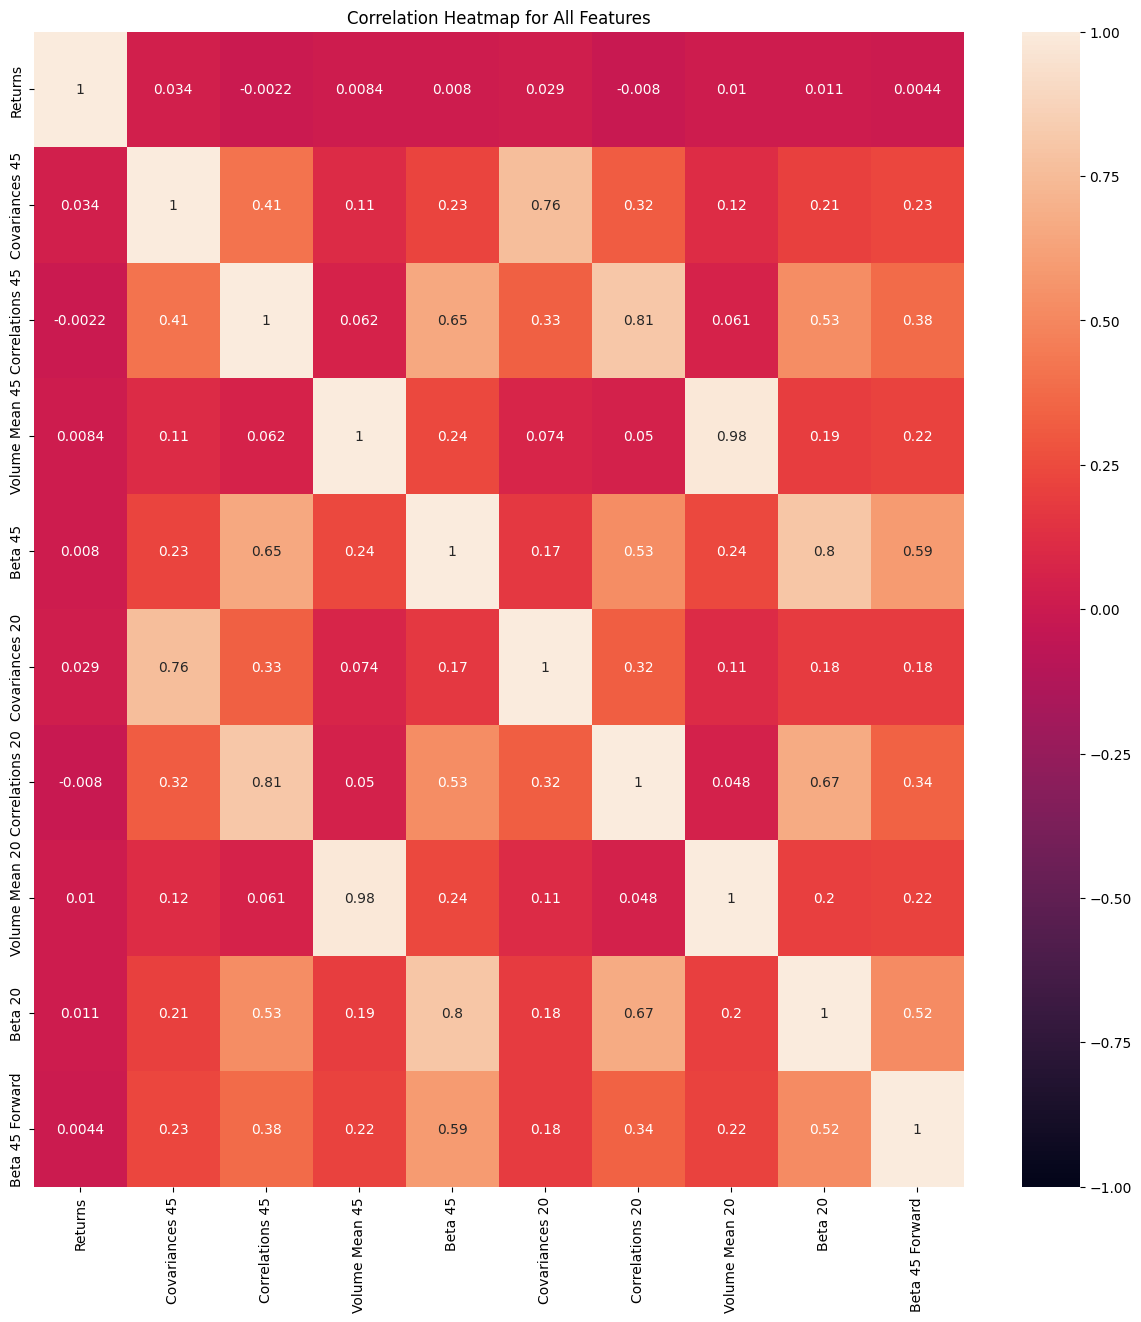

In [13]:
# Correlation matrix of the features
corr=df_all_features_flat.corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

# Set the title
plt.title('Correlation Heatmap for All Features')

# Show the plot
plt.show()

### From the correlation matrix we can see that Daily Returns are not very correlated to our target value so we will drop it in the following analysis, we also drop Valume 20 since it's highly correlated to Volume 45.

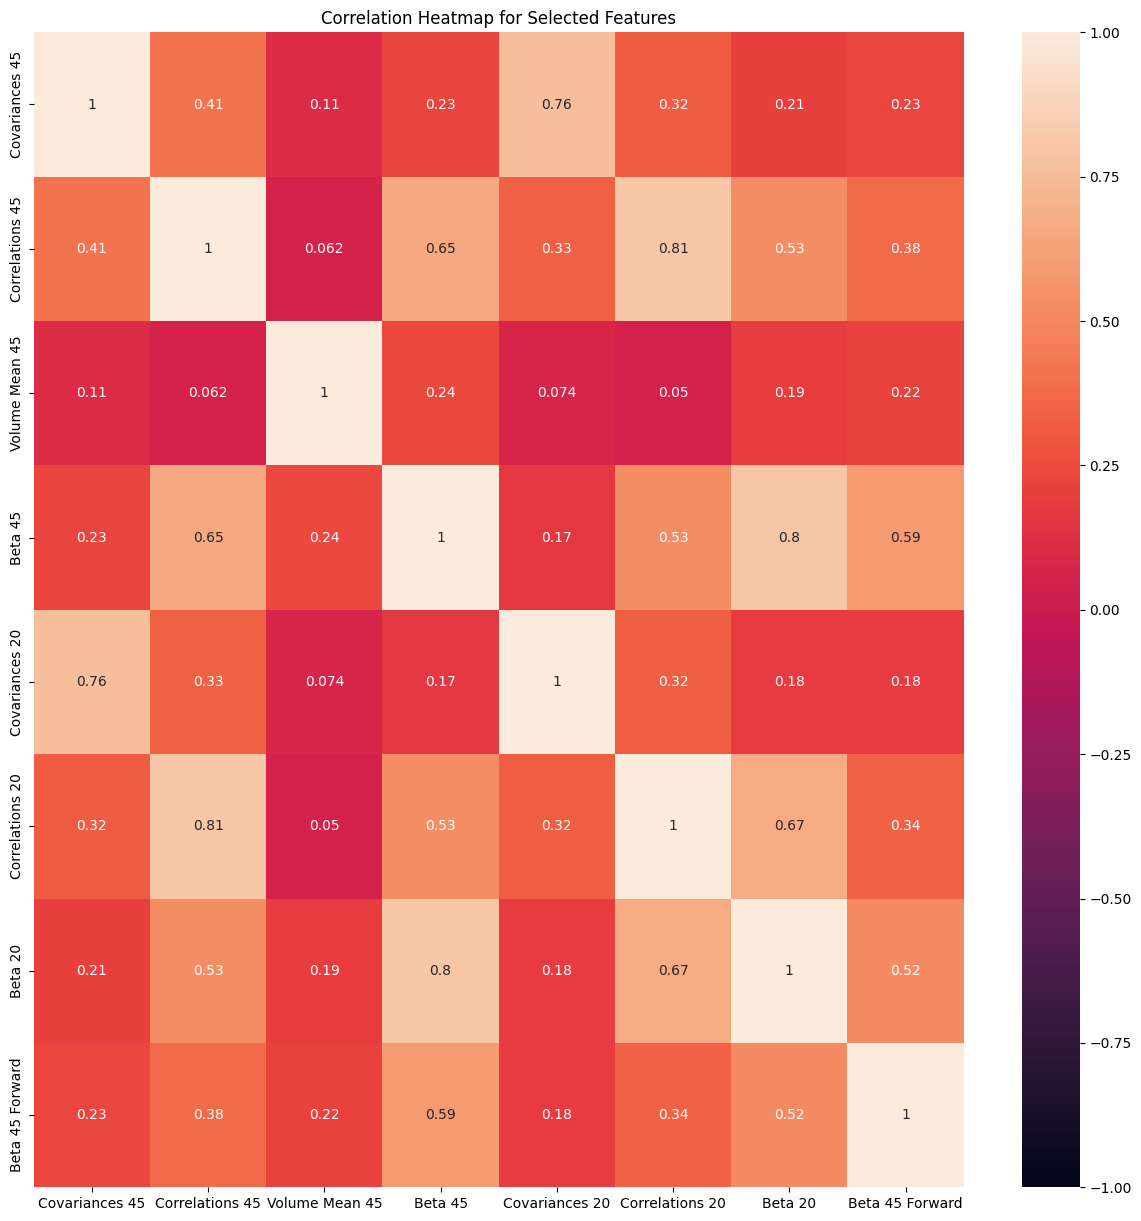

In [14]:
df_preprocessed = df_all_features_flat.drop(columns=['Returns', 'Volume Mean 20'])

# Correlation matrix of the selected features
corr=df_preprocessed.corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

# Set the title
plt.title('Correlation Heatmap for Selected Features')

# Show the plot
plt.show()

In [15]:
# Get some statistics on our preprocessed data
df_preprocessed.describe()

,Covariances 45,Correlations 45,Volume Mean 45,Beta 45,Covariances 20,Correlations 20,Beta 20,Beta 45 Forward
count,137100.000000,137100.000000,1.371000e+05,137100.000000,137100.000000,137100.000000,137100.000000,137100.000000
mean,0.000174,0.498966,6.666099e+06,0.954631,0.000174,0.491361,0.945900,0.948954
std,0.000370,0.232608,1.265356e+07,0.568851,0.000471,0.278056,0.706689,0.573629
min,-0.000232,-0.583878,1.350200e+05,-5.762717,-0.000426,-0.661517,-8.052835,-5.762717
25%,0.000039,0.346107,1.178236e+06,0.594867,0.000029,0.314115,0.532895,0.585091
50%,0.000076,0.526204,2.517437e+06,0.920258,0.000070,0.534946,0.903489,0.915716
75%,0.000155,0.675609,5.693897e+06,1.258148,0.000156,0.710185,1.299072,1.256535
max,0.004518,0.969074,1.367433e+08,6.913116,0.008009,0.987549,9.763848,6.913116


# Split into train, test data

In [16]:
X = df_preprocessed.drop('Beta 45 Forward', axis=1)
y = df_preprocessed['Beta 45 Forward']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Load, train and evaluate models
### In this case we use 3 of the most common and usually best performing models for regression problems: Linear Regression, Random Forest Regressor, and Gradient Boosting Regressor

In [17]:
# Load models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=123),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=123)
}

results = {}

# Get baseline results
results['Baseline'] = {
    'RMSE': df_preprocessed['Beta 45'].std(),
    'R2': 0
}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'RMSE': rmse,
        'R2': r2
    }


# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                       RMSE        R2
Baseline           0.568851  0.000000
Linear Regression  0.455237  0.379734
Random Forest      0.272959  0.777004
Gradient Boosting  0.425025  0.459331


### We evaluate all 3 models and compared them to a 'Baseline' model. This 'Baseline' model predicts the 45-day forward-looking beta as the mean of the target every time. Note that the RMSE and R2 of the baseline model are the target STD and 0, respectively, by definition.

### We see that the best performing model is the Random Forest Regressor with a RMSE of 0.27 and an R2 score of 0.78

### Let's interpret this results: 
### 1) The Random Forest RMSE corresponds to a 53% decrease compared to the data STD, this is a significant improvement over guessing the mean. 
### 2) The Random Forest R2 score of 0.78 implies that 78% of the variance in the target variable is explained by this model, compared to 0% in a model that guesses the mean every time.

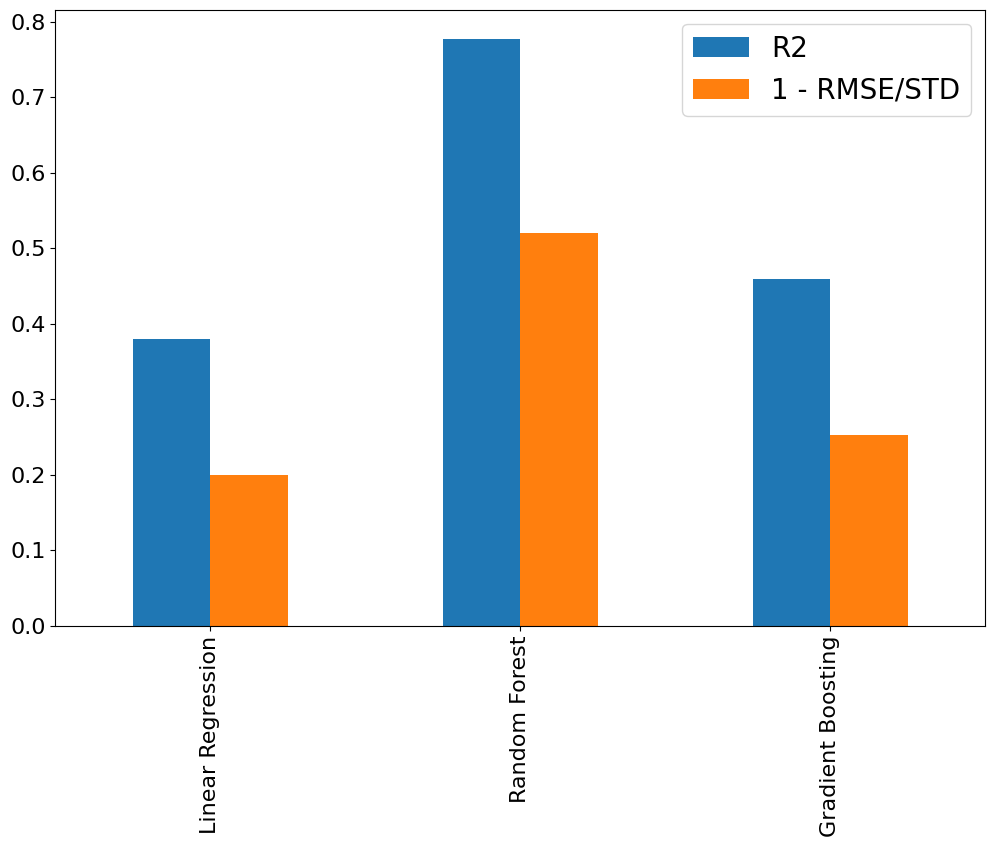

In [ ]:
# Create another feature '1 - RMSE/STD' to better compare how the model improves on the target's STD
results_df2 = results_df.copy()
results_df2['1 - RMSE/STD'] = 1 - results_df2['RMSE']/df_preprocessed['Beta 45'].std()
results_df2.drop(columns=['RMSE'], inplace=True)
results_df2 = results_df2.iloc[1:,:]

# Update rcParams for font sizes
plt.rcParams.update({
    'axes.labelsize': 16,  # Font size for x and y labels
    'xtick.labelsize': 12,  # Font size for x-axis tick labels
    'ytick.labelsize': 12   # Font size for y-axis tick labels
})

# Plot Results
plt.rc('legend',fontsize=20)
fig, ax = plt.subplots(figsize=(10, 5))
results_df2.plot(kind='bar', figsize=(12, 8), fontsize=16, ax=ax)
fig.savefig('Beta_Model_eval.jpg', dpi=300)

# Feature Importance Extraction

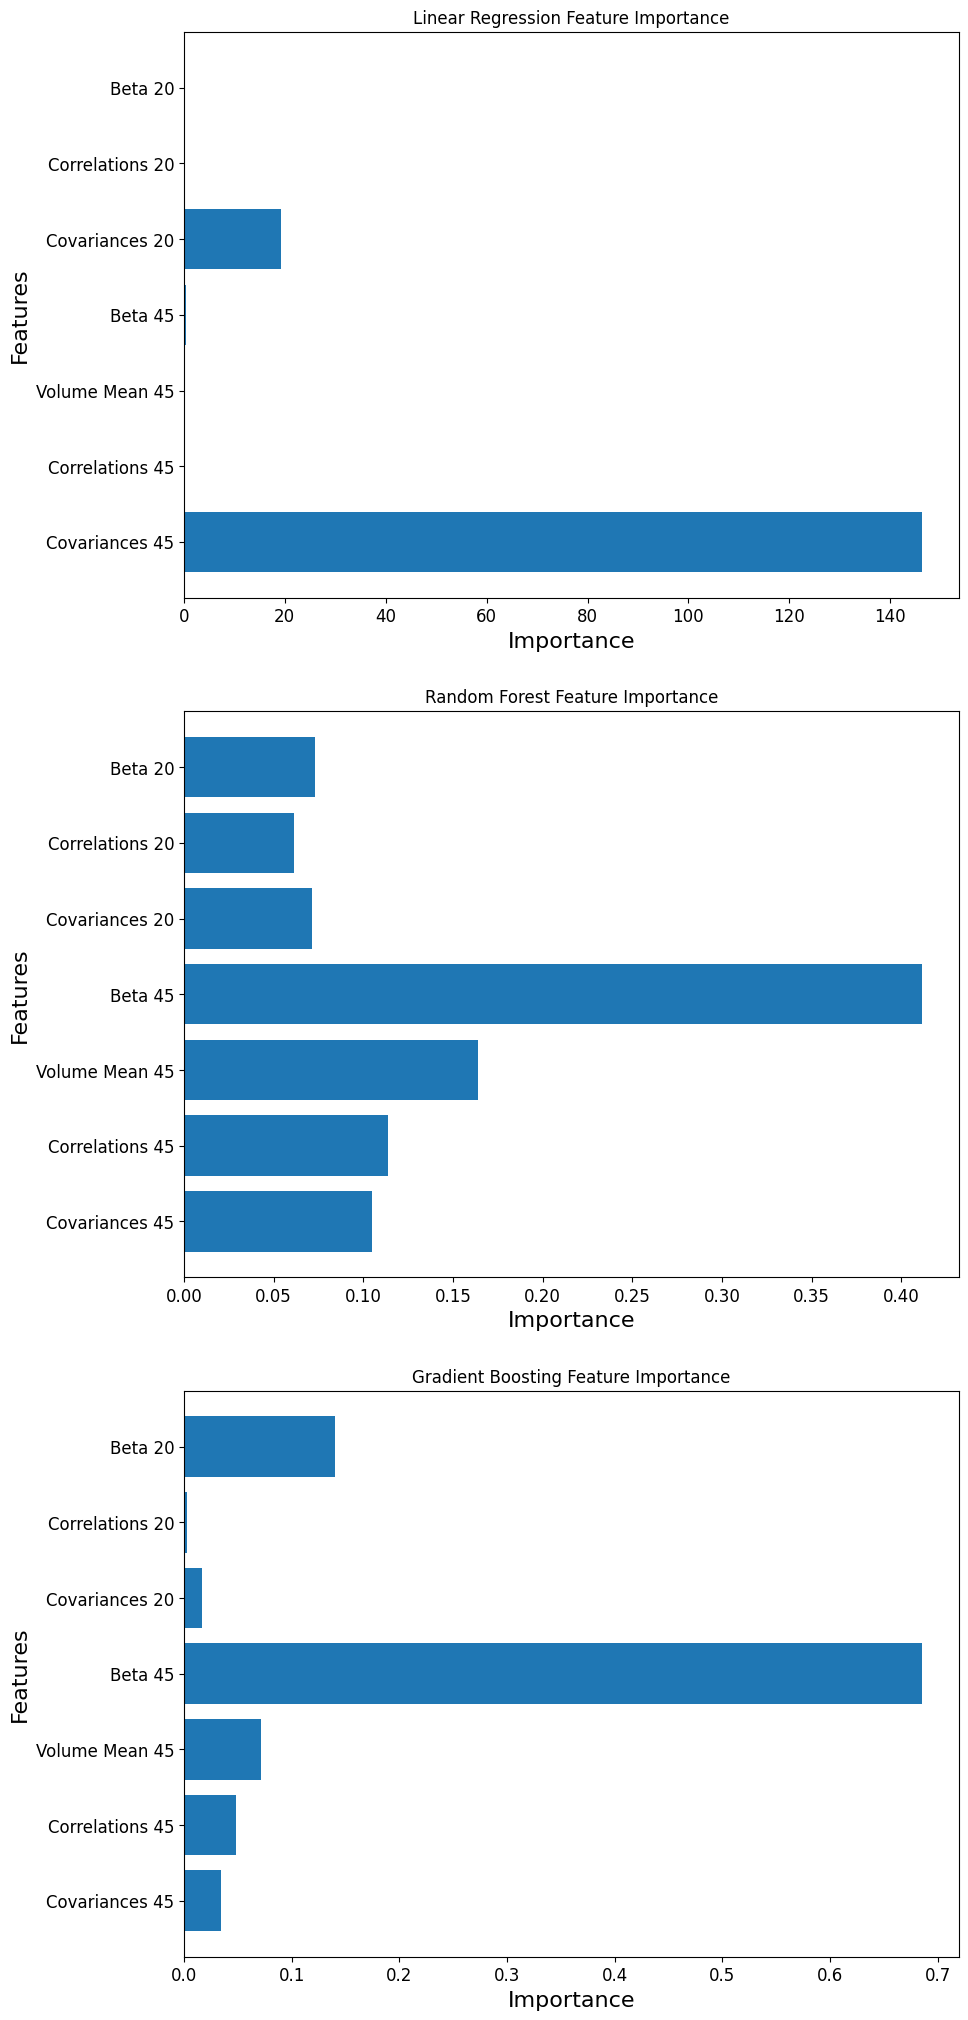

In [44]:
# Now we extract the feature importance or coefficients
importance = {}

# For Linear Regression, use the absolute value of the coefficients
importance['Linear Regression'] = np.abs(models['Linear Regression'].coef_)

# For Random Forest and Gradient Boosting, use the feature_importances_ attribute
importance['Random Forest'] = models['Random Forest'].feature_importances_
importance['Gradient Boosting'] = models['Gradient Boosting'].feature_importances_


# Extract features
features = X.columns

# Plot feature importance for each model in a bar plot
fig, ax = plt.subplots(3,1,figsize=(10, 25))

for i, (name, imp) in enumerate(importance.items(), start=1):
    ax[i-1].barh(features, imp)
    ax[i-1].set_title(f'{name} Feature Importance')
    ax[i-1].set_xlabel('Importance')
    ax[i-1].set_ylabel('Features')

fig.savefig('Beta_Feature_imp.jpg', dpi=300)

### Interestingly, the results show that for linear regression, the 45-day past Covariances are the most relevant feature by far. However, for the RF and GB Regressors the 45-day past Beta is the largest predictor of the 45-day future beta.